In [1]:
# Section 1: Imports and Configuration
import os
import numpy as np
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2025-08-28 09:02:05.968776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756371726.321553      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756371726.425803      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2986 image files. First 5:
['59261562828257.8985696.11.tiff', '55171562828257.9285893.3.tiff', '34721562828258.875228.22.tiff', '30741562828258.5222366.7.tiff', '92661562828258.719637.14.tiff']


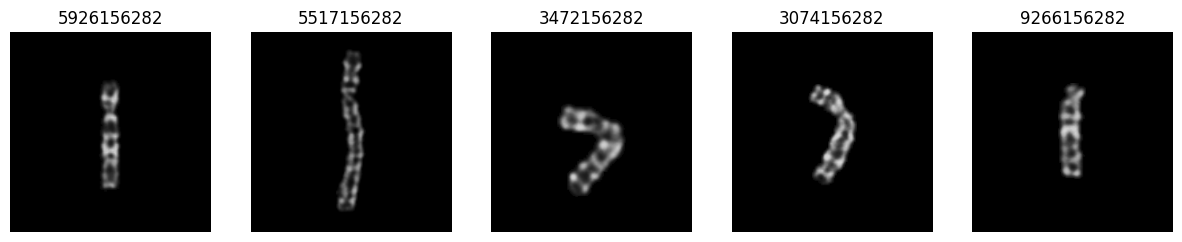

In [2]:
root = '/kaggle/input/dataset'
files = [f for f in os.listdir(root) if f.lower().endswith(('tiff','tif','jpg','jpeg','png'))]

print("Found", len(files), "image files. First 5:")
print(files[:5])

# Show first 5 images
plt.figure(figsize=(15, 3))
for i, fname in enumerate(files[:5]):
    img = Image.open(os.path.join(root, fname)).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(fname[:10])  # shortened title
plt.show()

In [3]:
NUM_CLASSES = 24
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4
DATA_PATH = Path('/kaggle/input/dataset')
AUGMENTED_PATH = Path('/kaggle/working/augmented_dataset')

def load_data():
    X, Y = [], []
    valid_ext = ('.jpg', '.jpeg', '.png', '.tiff', '.tif')

    for f in os.listdir(DATA_PATH):
        if f.lower().endswith(valid_ext):
            try:
                img_path = os.path.join(DATA_PATH, f)
                img = Image.open(img_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
                X.append(np.array(img, dtype=np.float32) / 255.0)

                # Label is last token before extension
                label_str = f.split('.')[-2]  # e.g. "11"
                label = int(label_str) - 1    # convert to 0-indexed
                if 0 <= label < NUM_CLASSES:
                    Y.append(label)
                else:
                    X.pop()

            except Exception as e:
                print(f"Error loading {f}: {e}")
                if X and len(X) > len(Y):
                    X.pop()

    X, Y = np.array(X), np.array(Y)
    print(f"Loaded {len(X)} images. Label distribution: {Counter(Y)}")
    return X, Y

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def get_callbacks(fold):
    return [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        ModelCheckpoint(f'/kaggle/working/best_model_fold_{fold}.h5', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
    ]

In [4]:
def create_model():
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=outputs)

In [5]:
X, Y = load_data()

os.makedirs(AUGMENTED_PATH, exist_ok=True)

augmenter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

X_augmented, Y_augmented = [], []

for i in range(len(X)):
    img = X[i]
    label = Y[i]

    # Save original image to augmented dataset
    X_augmented.append(img)
    Y_augmented.append(label)

    # Expand 5 augmented images per original
    img_exp = np.expand_dims(img, axis=0)
    aug_iter = augmenter.flow(img_exp, batch_size=1)
    for _ in range(5):
        aug_img = next(aug_iter)[0]
        X_augmented.append(aug_img)
        Y_augmented.append(label)

# Convert to numpy arrays
X_augmented = np.array(X_augmented)
Y_augmented = np.array(Y_augmented)

print(f"Augmented dataset size: {len(X_augmented)}. Label distribution: {Counter(Y_augmented)}")

Loaded 2856 images. Label distribution: Counter({2: 130, 13: 130, 8: 130, 3: 130, 19: 130, 20: 130, 16: 130, 9: 130, 4: 130, 11: 130, 18: 130, 12: 130, 15: 130, 0: 130, 5: 130, 1: 130, 7: 130, 10: 129, 6: 129, 14: 129, 17: 129, 21: 98, 22: 32})
Augmented dataset size: 17136. Label distribution: Counter({2: 780, 13: 780, 8: 780, 3: 780, 19: 780, 20: 780, 16: 780, 9: 780, 4: 780, 11: 780, 18: 780, 12: 780, 15: 780, 0: 780, 5: 780, 1: 780, 7: 780, 10: 774, 6: 774, 14: 774, 17: 774, 21: 588, 22: 192})


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_augmented, Y_augmented, test_size=0.2, stratify=Y_augmented, random_state=42
)

print("Training set:", X_train.shape, "Validation set:", X_val.shape)

Training set: (13708, 224, 224, 3) Validation set: (3428, 224, 224, 3)


In [7]:
model = create_model()
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    callbacks=get_callbacks(fold=1),
    verbose=1
)

val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"Final validation accuracy: {val_acc:.4f}")

I0000 00:00:1756371934.846264      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756371934.846937      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1756371976.646425     100 service.cc:148] XLA service 0x7de4f0002220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756371976.647942     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756371976.647966     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756371981.850472     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756371995.906096     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


429/429 ━━━━━━━━━━━━━━━━━━━━ 258s 482ms/step - accuracy: 0.1742 - loss: 3.8607 - val_accuracy: 0.3985 - val_loss: 2.5192 - learning_rate: 1.0000e-04
Epoch 2/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 164s 381ms/step - accuracy: 0.3204 - loss: 2.9443 - val_accuracy: 0.5044 - val_loss: 2.1988 - learning_rate: 1.0000e-04
Epoch 3/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 160s 373ms/step - accuracy: 0.3899 - loss: 2.6488 - val_accuracy: 0.4880 - val_loss: 2.2225 - learning_rate: 1.0000e-04
Epoch 4/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 162s 378ms/step - accuracy: 0.4344 - loss: 2.4800 - val_accuracy: 0.5828 - val_loss: 1.9263 - learning_rate: 1.0000e-04
Epoch 5/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 161s 374ms/step - accuracy: 0.4739 - loss: 2.3077 - val_accuracy: 0.6135 - val_loss: 1.8419 - learning_rate: 1.0000e-04
Epoch 6/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 164s 382ms/step - accuracy: 0.5042 - loss: 2.1664 - val_accuracy: 0.6348 - val_loss: 1.7563 - learning_rate: 1.0000e-04
Epoch 7/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 162s 377ms/

In [8]:
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, 'chromosome_classifier_final.h5'))

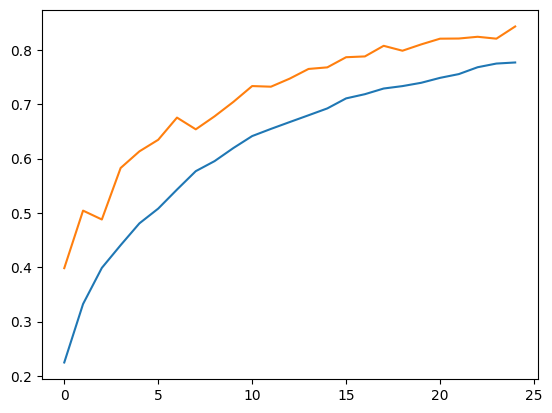

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [10]:
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Section 7: Analysis
def analyze_original(model, image_path='original.jpg'):
    if not Path(image_path).exists():
        print(f"Original image {image_path} not found")
        return
    
    # Get segmented chromosomes
    chromosomes = segment_chromosomes(image_path)
    if len(chromosomes) == 0:
        print("No chromosomes detected")
        return
    
    # Predict
    preds = model.predict(np.array(chromosomes))  # ensure it's a numpy array
    classes = np.argmax(preds, axis=1)
    confs = np.max(preds, axis=1)
    
    print(f"\n=== CHROMOSOME ANALYSIS ===")
    print(f"Total chromosomes detected: {len(chromosomes)}")
    for cid, cnt in Counter(classes).items():
        chr_name = f"Chr {cid+1}" if cid <= 21 else ("Chr X" if cid==22 else "Chr Y")
        print(f"{chr_name}: {cnt}")
    
    # Visualization
    n_cols = 4
    n_rows = int(np.ceil(len(chromosomes)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(chromosomes):
            ax.imshow(chromosomes[i])
            chr_name = f"Chr {classes[i]+1}" if classes[i]<=21 else ("Chr X" if classes[i]==22 else "Chr Y")
            ax.set_title(f"{chr_name}\n{confs[i]:.3f}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return chromosomes, classes, confs  # Return for further use if needed

# Example usage
chromosomes, classes, confs = analyze_original(best_model, image_path='original.jpg')

NameError: name 'best_model' is not defined